In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Dataset/crop1.csv'
fb = pd.read_csv(data)

In [ ]:
print(fb.head())
print(fb.info())
print(fb.describe())

          Area                 Item         Element  Year Unit   Value
0  Afghanistan  Almonds, with shell  Area harvested  1975   ha     0.0
1  Afghanistan  Almonds, with shell  Area harvested  1976   ha  5900.0
2  Afghanistan  Almonds, with shell  Area harvested  1977   ha  6000.0
3  Afghanistan  Almonds, with shell  Area harvested  1978   ha  6000.0
4  Afghanistan  Almonds, with shell  Area harvested  1979   ha  6000.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895975 entries, 0 to 1895974
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Area     object 
 1   Item     object 
 2   Element  object 
 3   Year     int64  
 4   Unit     object 
 5   Value    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 86.8+ MB
None
               Year         Value
count  1.895975e+06  1.766475e+06
mean   1.992321e+03  1.077275e+06
std    1.718118e+01  1.403138e+07
min    1.961000e+03  0.000000e+00
25%    1.978000e+03  4.500000e+03
50%    1.99400

In [ ]:
print(fb.duplicated().sum()) #no duplication

0


In [ ]:
missing = fb.isnull().sum()
missing = missing[missing > 0]  #keep only features with missing values

missing_summary = pd.DataFrame({
    'Feature': missing.index,
    'Missing Count': missing.values,
    'Missing %': (missing.values / len(fb) * 100).round(2)
})

print(missing_summary) #missing values only on Values features

  Feature  Missing Count  Missing %
0   Value         129500       6.83


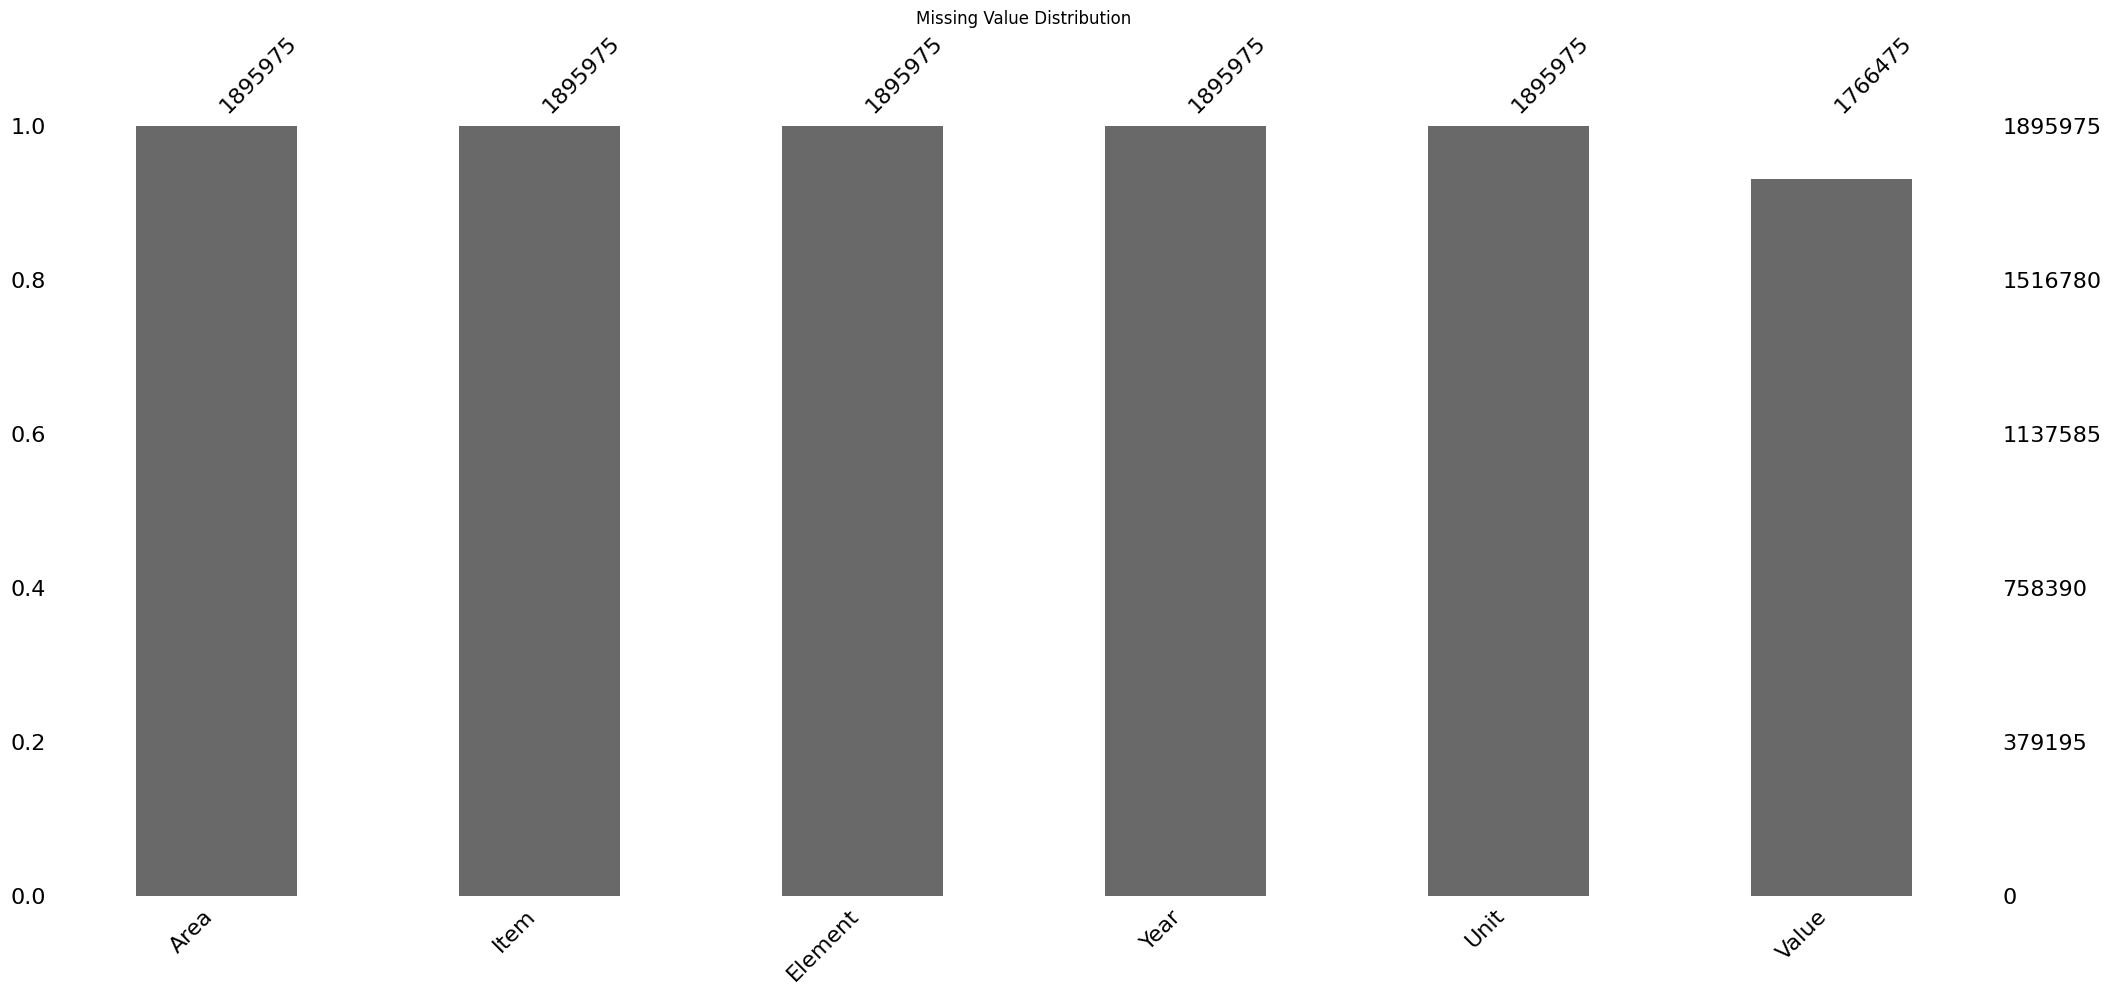

In [ ]:
!pip install missingno

import missingno as msno
import matplotlib.pyplot as plt

msno.bar(fb)
plt.title("Missing Value Distribution")
plt.show() #Missing values visualization inspection

In [ ]:
def diagnose_missingness(fb, target_col='Value', group_col='Area', num_col='Year'):

    fb = fb.copy()
    fb['missing_flag'] = fb[target_col].isnull()

    #Proportion of missing by group_col
    missing_by_group = fb.groupby(['missing_flag', group_col]).size().unstack(fill_value=0)

    if True in missing_by_group.index:
        missing_group_percent = (
            (missing_by_group.loc[True]) / missing_by_group.sum()
        ).sort_values(ascending=False)
        print(f"\n Missing Proportion by '{group_col}' (Top 10):")
        print(missing_group_percent.head(10))
    else:
        print(f"\n No missing values found in '{target_col}'")

    # Mean/median/count of numerical column by missing flag
    print(f"\n '{num_col}' statistics grouped by missing_flag for '{target_col}':")
    print(fb.groupby('missing_flag')[num_col].agg(['count', 'mean', 'median']).round(2))

diagnose_missingness(fb, target_col='Value', group_col='Area', num_col='Year') #Concluded as MAR as missing values depends on Area and Year


 Missing Proportion by 'Area' (Top 10):
Area
China, Macao SAR                    0.677419
South Sudan                         0.495726
Palestine                           0.475667
Bahamas                             0.376623
Namibia                             0.301544
Bhutan                              0.285144
Singapore                           0.280827
Belize                              0.276244
Micronesia (Federated States of)    0.275862
Saint Lucia                         0.271454
dtype: float64

 'Year' statistics grouped by missing_flag for 'Value':
                count     mean  median
missing_flag                          
False         1766475  1992.85  1994.0
True           129500  1985.06  1982.0


Skewness of 'Value': 50.22110242633808
Kurtosis: 4097.453497861577


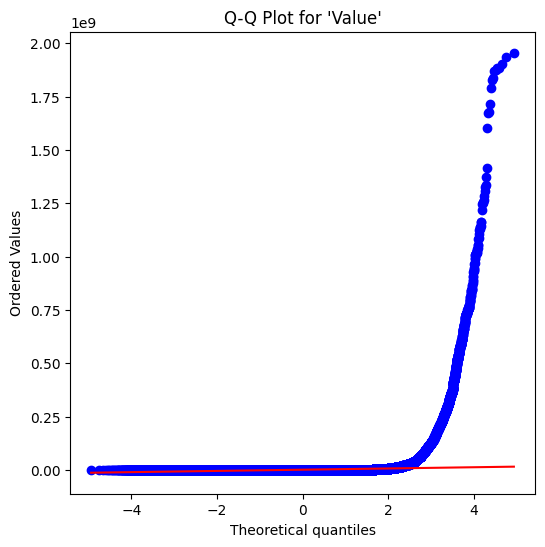

In [ ]:
print("Skewness of 'Value':", fb['Value'].skew()) #Extremely positive skewed
print("Kurtosis:", fb['Value'].kurt()) #Extremely leptokurtic


import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(fb['Value'].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot for 'Value'")
plt.show() #points deviate sharply from the diagonal line

In [ ]:
#Since MAR subsists, imputation methods are generally preferred over deletion, as deletion can introduce bias
'''
Data is heavily skewed with outliers present
Data handled by non-parametric approach using median imputation rather than mean
Fact is data not followed normality distribution

Multi-Level imputation strategy for addressing:
a. Value features entirely missing
b. Had too few data points to calculate a usable median
'''

#Impute by (Area, Item)
fb['Value'] = fb.groupby(['Area', 'Item'])['Value'].transform(lambda x: x.fillna(x.median()))

#Impute remaining missing by 'Item' alone (broader group)
fb['Value'] = fb.groupby('Item')['Value'].transform(lambda x: x.fillna(x.median()))

#Fill any final missing with global median
fb['Value'] = fb['Value'].fillna(fb['Value'].median())

#Confirm no missing values remain
print("Remaining missing in 'Value':", fb['Value'].isnull().sum()) #No missing values retained

#Descriptives ummary
print(fb['Value'].describe()) #No obvious corruption, deletion bias, and data is realistic and consistent

Remaining missing in 'Value': 0
count    1.895975e+06
mean     1.005019e+06
std      1.354635e+07
min      0.000000e+00
25%      3.718000e+03
50%      2.295100e+04
75%      1.181570e+05
max      1.955308e+09
Name: Value, dtype: float64


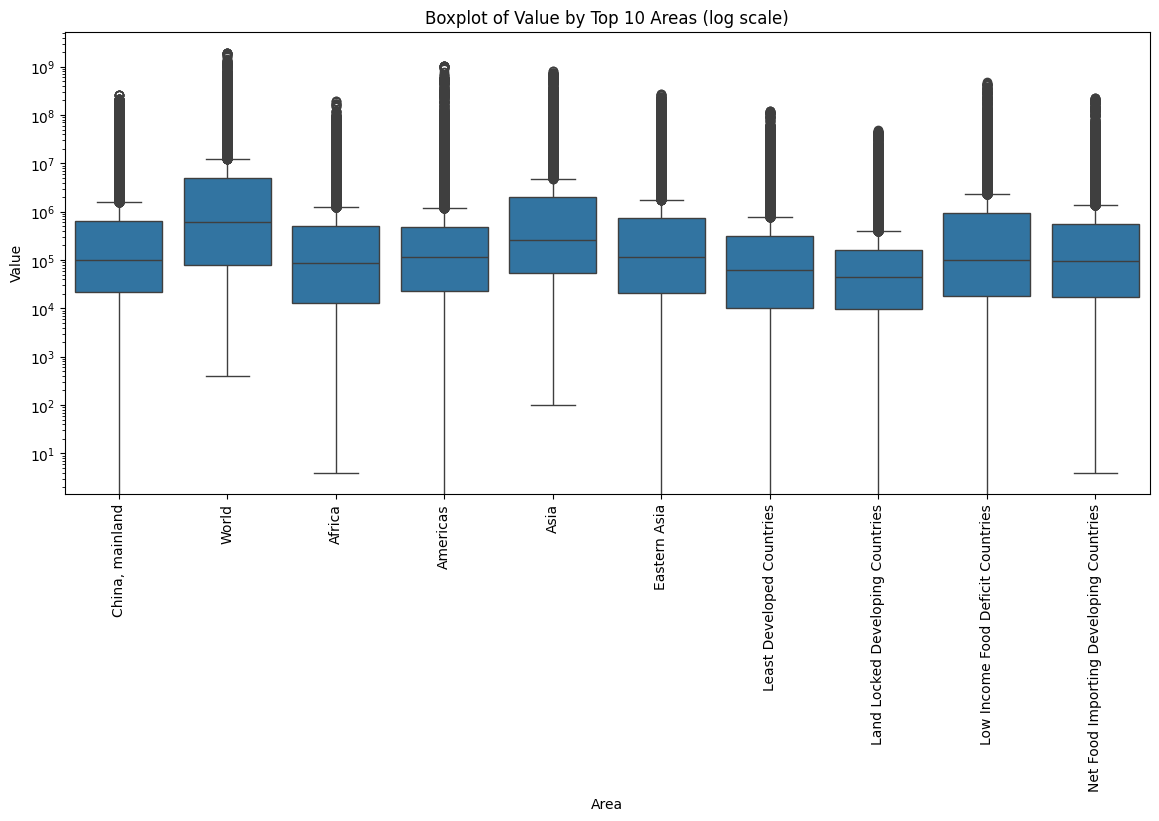

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_areas = fb['Area'].value_counts().nlargest(10).index
subset = fb[fb['Area'].isin(top_areas)]  #To handle large unique Area count by limit to Top 10 output

plt.figure(figsize=(14,6))
sns.boxplot(data=subset, x='Area', y='Value')  #Subset introduced
plt.xticks(rotation=90)
plt.yscale('log')  #Log scale for extremely skewed data preventing value stretch
plt.title('Boxplot of Value by Top 10 Areas (log scale)') #Year features served as chronological range
plt.show()

In [ ]:
def flag_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

fb['is_outlier'] = fb.groupby(['Area', 'Item'])['Value'].transform(flag_outliers_iqr)

print(f"Outlier count: {fb['is_outlier'].sum()}")
print(f"Outlier percentage: {fb['is_outlier'].mean() * 100:.4f}%")

Outlier count: 136959
Outlier percentage: 7.2237%


/tmp/ipython-input-13-1214669574.py:4: FutureWarning: The provided callable <function sum at 0x7e68b25c1300> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_outliers = fb.pivot_table(index='Area', columns='Year', values='is_outlier', aggfunc=np.sum, fill_value=0)


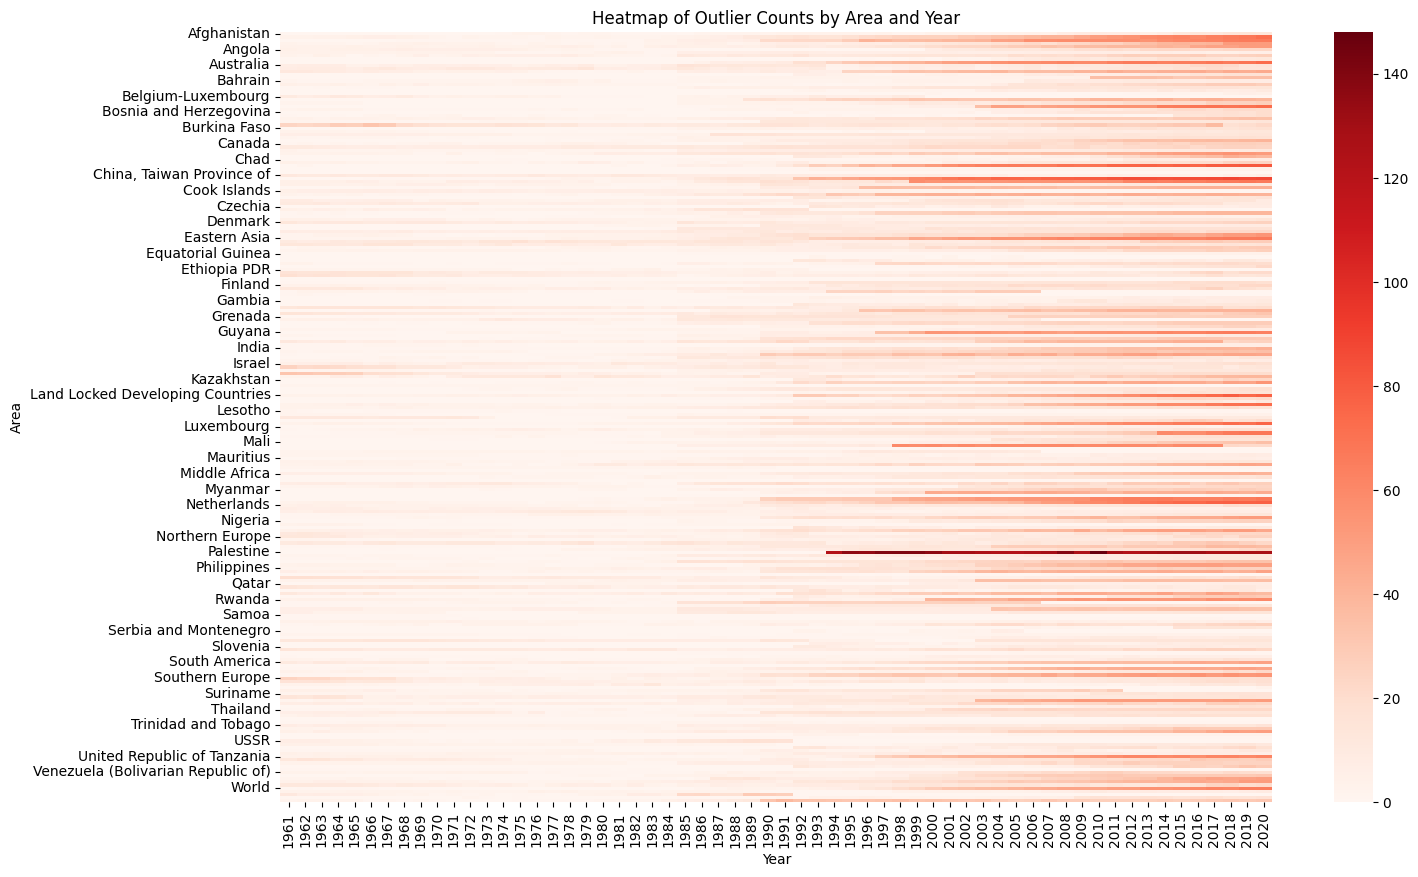

In [ ]:
import numpy as np

# Pivot table for outlier counts by Area and Year
pivot_outliers = fb.pivot_table(index='Area', columns='Year', values='is_outlier', aggfunc=np.sum, fill_value=0)

plt.figure(figsize=(16,10))
sns.heatmap(pivot_outliers, cmap='Reds')
plt.title('Heatmap of Outlier Counts by Area and Year')
plt.show() #Consistent concentration with logical hue throughout Year trend

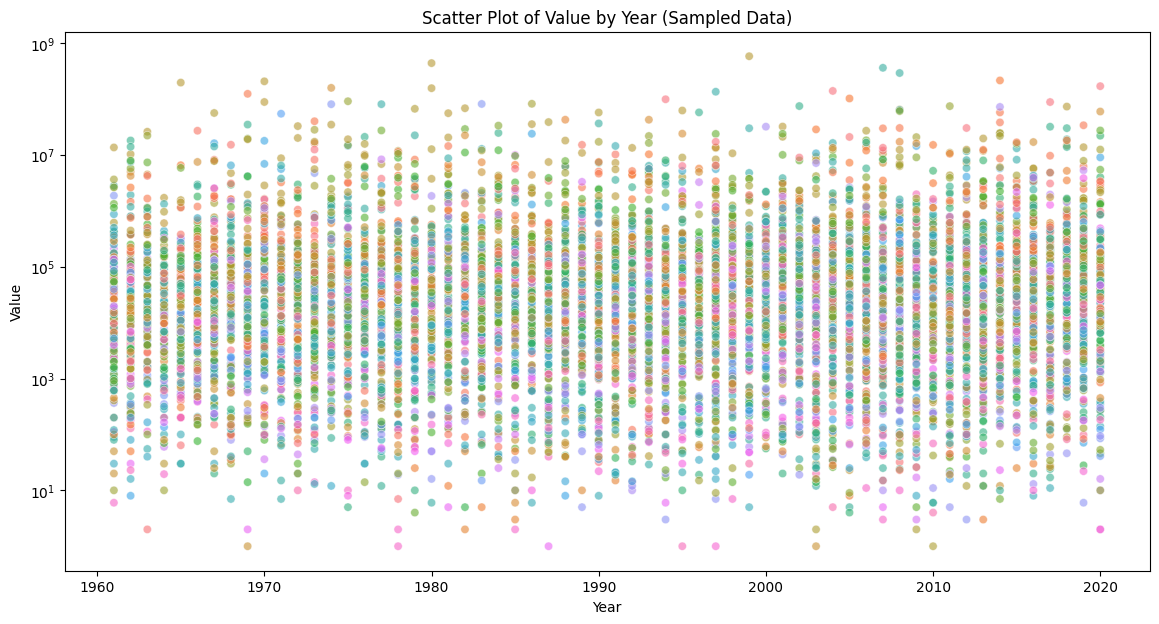

In [ ]:
sampled = fb.sample(10000, random_state=42)  #Sample to speed up

plt.figure(figsize=(14,7))
sns.scatterplot(data=sampled, x='Year', y='Value', hue='Area', legend=False, alpha=0.6)
plt.yscale('log')
plt.title('Scatter Plot of Value by Year (Sampled Data)')
plt.show() #Consistent plotting

In [ ]:
import numpy as np

def treat_outliers(df, column, log_transform=True, winsorize=True, q_low=0.01, q_high=0.99):
    """
    Apply log transformation and/or winsorization to a numeric column.

    Parameters:
        df: pandas DataFrame
        column: target numeric column (string)
        log_transform: whether to add log-transformed column (default: True)
        winsorize: whether to add winsorized column (default: True)
        q_low: lower quantile for winsorization (default: 0.01)
        q_high: upper quantile for winsorization (default: 0.99)

    Returns:
        df: original DataFrame with new columns added
    """
    if log_transform:
        df[f"{column}_log"] = np.log1p(df[column])

    if winsorize:
        lower = df[column].quantile(q_low)
        upper = df[column].quantile(q_high)
        df[f"{column}_winsor"] = df[column].clip(lower=lower, upper=upper)

    return df

fb = treat_outliers(fb, column='Value')

In [ ]:
def verify_treatment(df, column, q_low=0.01, q_high=0.99):
    """
    Verify if outlier treatment was applied correctly.

    Checks:
    - New columns exist
    - Max/min value comparison
    - Count of capped values
    - Missing values in treated columns
    """
    log_col = f"{column}_log"
    winsor_col = f"{column}_winsor"

    print("Column Check:")
    print(f"  {log_col} exists:", log_col in df.columns)
    print(f"  {winsor_col} exists:", winsor_col in df.columns)

    print("\n Max/Min Comparison:")
    if winsor_col in df.columns:
        print(f"  Original max: {df[column].max():,.2f}")
        print(f"  Winsorized max: {df[winsor_col].max():,.2f}")
        print(f"  Original min: {df[column].min():,.2f}")
        print(f"  Winsorized min: {df[winsor_col].min():,.2f}")

        upper = df[column].quantile(q_high)
        lower = df[column].quantile(q_low)

        capped_high = (df[column] > upper).sum()
        capped_low = (df[column] < lower).sum()

        print(f"\n Values capped above 99th percentile: {capped_high}")
        print(f" Values capped below 1st percentile: {capped_low}")

    print("\n Null Checks:")
    for col in [log_col, winsor_col]:
        if col in df.columns:
            print(f"  Missing in {col}: {df[col].isnull().sum()}")

verify_treatment(fb, column='Value')

Column Check:
  Value_log exists: True
  Value_winsor exists: True

 Max/Min Comparison:
  Original max: 1,955,307,695.00
  Winsorized max: 16,246,014.06
  Original min: 0.00
  Winsorized min: 5.00

 Values capped above 99th percentile: 18960
 Values capped below 1st percentile: 18421

 Null Checks:
  Missing in Value_log: 0
  Missing in Value_winsor: 0


In [ ]:
fb_cleaned = fb.copy() #Random Forest quite robust and can handle extreme values well
fb_cleaned['Value_cleaned'] = fb_cleaned['Value_log'] #ANN, SVM, Linear Regression very sensitive, hence log were choose

In [ ]:
from scipy.stats import zscore
import numpy as np

z_scores = np.abs(zscore(fb_cleaned['Value_cleaned']))

outliers = (z_scores > 3).sum()

total_rows = len(fb_cleaned)

outlier_pct = (outliers / total_rows) * 100

print(f"Outliers remaining after log transform: {outliers}")
print(f"Outlier percentage: {outlier_pct:.4f}%")

Outliers remaining after log transform: 18450
Outlier percentage: 0.9731%


In [ ]:
# Quick cardinality & dtype report
summary = (
    fb_cleaned
      .agg(['nunique', 'dtype'])     # how many distinct values & dtype
      .T                             # tabular view
      .reset_index(names='Feature')
      .sort_values('nunique', ascending=False)
)
print(summary)

         Feature nunique    dtype
5          Value  420521  float64
7      Value_log  420521  float64
9  Value_cleaned  420521  float64
8   Value_winsor  401892  float64
0           Area     245   object
1           Item     118   object
3           Year      60    int64
2        Element       3   object
4           Unit       3   object
6     is_outlier       2     bool


In [ ]:
print("Element unique values:", fb_cleaned['Element'].unique())
print("Unit unique values:", fb_cleaned['Unit'].unique())

year_min = fb_cleaned['Year'].min()
year_max = fb_cleaned['Year'].max()
print(f"Year range: {year_min} to {year_max}")

Element unique values: ['Area harvested' 'Yield' 'Production']
Unit unique values: ['ha' 'hg/ha' 'tonnes']
Year range: 1961 to 2020


In [ ]:
fb_ready = fb_cleaned.copy()

In [ ]:
# Binning Year into Decade
fb_ready['Decade'] = (fb_ready['Year'] // 10) * 10

print(fb_ready['Decade'].unique())
print(fb_ready['Decade'].value_counts().sort_index())

[1970 1980 1990 2000 2010 2020 1960]
Decade
1960    245719
1970    278060
1980    290567
1990    339015
2000    352710
2010    354498
2020     35406
Name: count, dtype: int64


In [ ]:
area_freq = fb_ready['Area'].value_counts()
print(area_freq.head(10))   # Top 10 most common areas
print(area_freq.tail(10))  # Bottom 10 least common areas


item_freq = fb_ready['Item'].value_counts()
print(item_freq.head(10))   # Top 10 most common items
print(item_freq.tail(10))  # Bottom 10 least common items

Area
World                                      21193
Asia                                       21154
Net Food Importing Developing Countries    20523
Americas                                   20322
Eastern Asia                               20313
Low Income Food Deficit Countries          20112
Africa                                     20051
China, mainland                            19765
Least Developed Countries                  19005
Land Locked Developing Countries           18974
Name: count, dtype: int64
Area
Kiribati                            1228
Equatorial Guinea                   1207
South Sudan                         1053
Micronesia (Federated States of)     986
Tokelau                              660
Tuvalu                               633
Nauru                                596
China, Macao SAR                     558
Faroe Islands                        180
Marshall Islands                      90
Name: count, dtype: int64
Item
Vegetables, fresh nes           3

In [ ]:
def reduce_cardinality(df, column, top_n=30):
    """
    Keeps top N most frequent values in a column, replaces the rest with 'Other'.

    Args:
        df (pd.DataFrame): The dataframe.
        column (str): Column to reduce cardinality.
        top_n (int): Number of top frequent values to keep.

    Returns:
        pd.DataFrame: Updated dataframe with reduced cardinality.
    """
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    return df

# Apply to your dataframe (fb_ready assumed here)
fb_ready = reduce_cardinality(fb_ready, 'Area', top_n=30)
fb_ready = reduce_cardinality(fb_ready, 'Item', top_n=45)


print(fb_ready['Area'].nunique())
print(fb_ready['Item'].nunique())

print(fb_ready['Area'].value_counts().head())
print(fb_ready['Area'].value_counts().tail())

31
46
Area
Other                                      1365113
World                                        21193
Asia                                         21154
Net Food Importing Developing Countries      20523
Americas                                     20322
Name: count, dtype: int64
Area
Turkey                            14908
Northern America                  14765
Eastern Europe                    14697
Small Island Developing States    14432
United States of America          14417
Name: count, dtype: int64


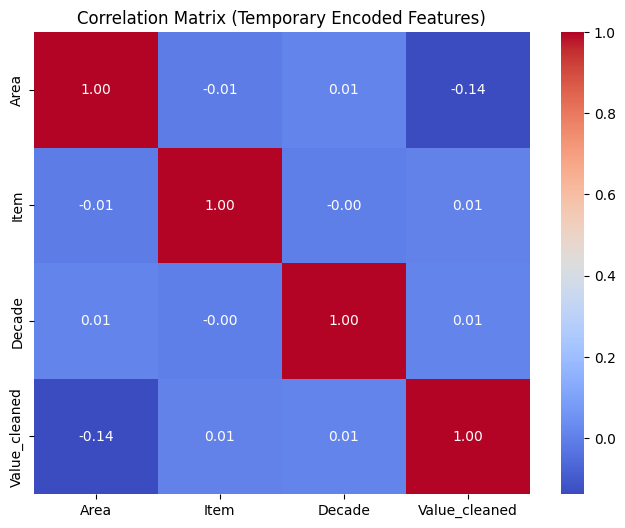

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy for inspection
fb_check = fb_ready.copy()

# Temporary label encoding for correlation check
label_encoders = {}
for col in ['Area', 'Item', 'Decade']:
    le = LabelEncoder()
    fb_check[col] = le.fit_transform(fb_check[col])
    label_encoders[col] = le  # Save if needed later

# Select features to check
corr_features = ['Area', 'Item', 'Decade', 'Value_cleaned']

# Correlation matrix
corr_matrix = fb_check[corr_features].corr()

# Visualize
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Temporary Encoded Features)')
plt.show() #No multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Only numeric columns
X = fb_check[['Area', 'Item', 'Decade']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Feature       VIF
0    Area  5.513232
1    Item  4.730361
2  Decade  3.174574


In [ ]:
from sklearn.preprocessing import LabelEncoder

fb_ready['Area_enc'] = LabelEncoder().fit_transform(fb_ready['Area'])
fb_ready['Item_enc'] = LabelEncoder().fit_transform(fb_ready['Item'])
fb_ready['Decade_enc'] = LabelEncoder().fit_transform(fb_ready['Decade'])

features = ['Area_enc', 'Item_enc', 'Decade_enc']  #No need add Year since already reduce dimensionality
target = 'Value_cleaned'

In [ ]:
print(fb_ready.columns.tolist())

['Area', 'Item', 'Element', 'Year', 'Unit', 'Value', 'is_outlier', 'Value_log', 'Value_winsor', 'Value_cleaned', 'Decade', 'Area_enc', 'Item_enc', 'Decade_enc']


In [ ]:
# Split by element type
df_production = fb_ready[fb_ready['Element'] == 'Production'].copy()
df_yield = fb_ready[fb_ready['Element'] == 'Yield'].copy()
df_area = fb_ready[fb_ready['Element'] == 'Area harvested'].copy()

# Assign 'Target'
df_production['Target'] = df_production['Value_cleaned']
df_yield['Target'] = df_yield['Value_cleaned']
df_area['Target'] = df_area['Value_cleaned']

# Create X, y
X_production = df_production[features]
y_production = df_production['Target']

X_yield = df_yield[features]
y_yield = df_yield['Target']

X_area = df_area[features]
y_area = df_area['Target']


print("Production:", X_production.shape, y_production.shape)
print("Yield:", X_yield.shape, y_yield.shape)
print("Area harvested:", X_area.shape, y_area.shape)

Production: (663735, 3) (663735,)
Yield: (575730, 3) (575730,)
Area harvested: (656510, 3) (656510,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale Production dataset
X_production_scaled = scaler.fit_transform(X_production)

# Scale Yield dataset
X_yield_scaled = scaler.fit_transform(X_yield)

# Scale Area Harvested dataset
X_area_scaled = scaler.fit_transform(X_area)

In [ ]:
from sklearn.model_selection import train_test_split

# Filter only Production rows
df_production = fb_ready[fb_ready['Element'] == 'Production'].copy()

# One-Hot Encode categorical features
X = pd.get_dummies(df_production[['Area', 'Item', 'Decade']], drop_first=True)

# Target
y = df_production['Value_cleaned']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs (for ANN & Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Build ANN
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))

# Compile
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = ann_model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Predict
y_pred_ann = ann_model.predict(X_test_scaled).flatten()

# Evaluate
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("\nANN Results:")
print(f"MSE: {mse_ann:.2f}")
print(f"R² Score: {r2_ann:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 10.5643 - mae: 2.4136 - val_loss: 7.2346 - val_mae: 2.0451
Epoch 2/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 7.2329 - mae: 2.0468 - val_loss: 7.3042 - val_mae: 2.0344
Epoch 3/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 7.1444 - mae: 2.0266 - val_loss: 7.2130 - val_mae: 2.0270
Epoch 4/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 7.1732 - mae: 2.0261 - val_loss: 7.1482 - val_mae: 2.0169
Epoch 5/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 7.1414 - mae: 2.0191 - val_loss: 7.1865 - val_mae: 2.0594
Epoch 6/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 7.1342 - mae: 2.0194 - val_loss: 7.1060 - val_mae: 2.0074
Epoch 7/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 7.1173 - mae: 2.0133 - val_loss: 7.0933 - val_mae: 2.0070
Epoch 8/20
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 7.1207 - mae: 2.0131 - val_loss: 7.1671 - val_mae: 2.0131
Epoch 9/20
6638/6638 ━━━━━━━━━━

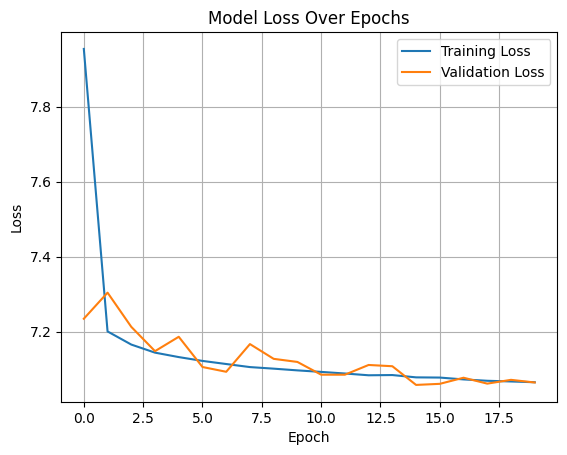

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict again using your trained ANN model
y_pred_ann = ann_model.predict(X_test_scaled).flatten()  # Flatten to match y_test shape if needed

4149/4149 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


Different version of ANN (prefer previous version)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

y_pred_ann = model.predict(X_test_scaled).flatten()

# Evaluation
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("ANN Results:")
print(f"MSE: {mse_ann:.2f}")
print(f"R² Score: {r2_ann:.4f}")

Epoch 1/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 11.0596 - mae: 2.5479 - val_loss: 10.2114 - val_mae: 2.6492
Epoch 2/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 7.5327 - mae: 2.1245 - val_loss: 8.2428 - val_mae: 2.3228
Epoch 3/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 7.4215 - mae: 2.1000 - val_loss: 7.8021 - val_mae: 2.2308
Epoch 4/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 7.3038 - mae: 2.0797 - val_loss: 8.1599 - val_mae: 2.3041
Epoch 5/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 7.2465 - mae: 2.0651 - val_loss: 8.2815 - val_mae: 2.3316
Epoch 6/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 7.3017 - mae: 2.0698 - val_loss: 7.8975 - val_mae: 2.2524
Epoch 7/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 7.2491 - mae: 2.0593 - val_loss: 7.8683 - val_mae: 2.2481
Epoch 8/50
6638/6638 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 7.2240 - mae: 2.0533 - val_loss: 7.8518 - val_mae: 2.2454
Epoch 9/50
6638/6638 ━━━━━━━━━

Previous version model plot with lesser epochs

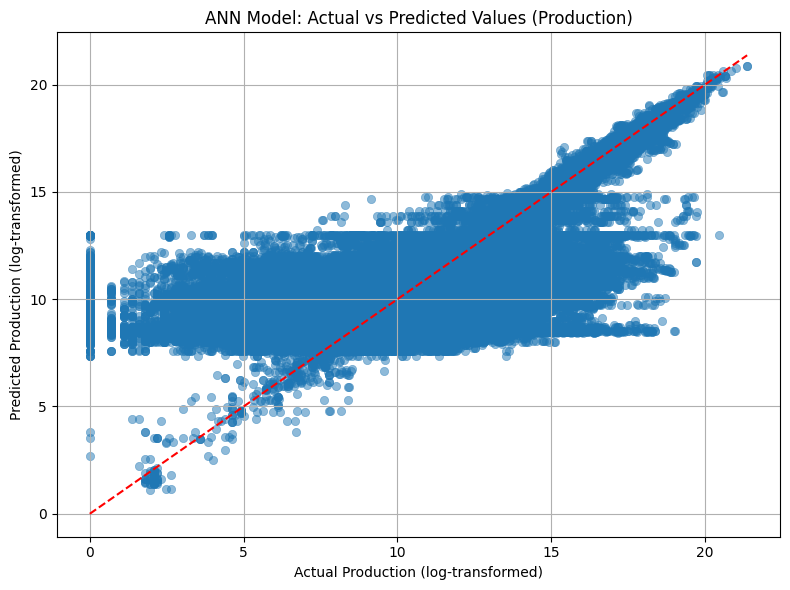

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_ann, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal line

plt.title('ANN Model: Actual vs Predicted Values (Production)')
plt.xlabel('Actual Production (log-transformed)')
plt.ylabel('Predicted Production (log-transformed)')
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results for Production Dataset")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

Random Forest Results for Production Dataset
Mean Squared Error (MSE): 6.96
R² Score: 0.3765


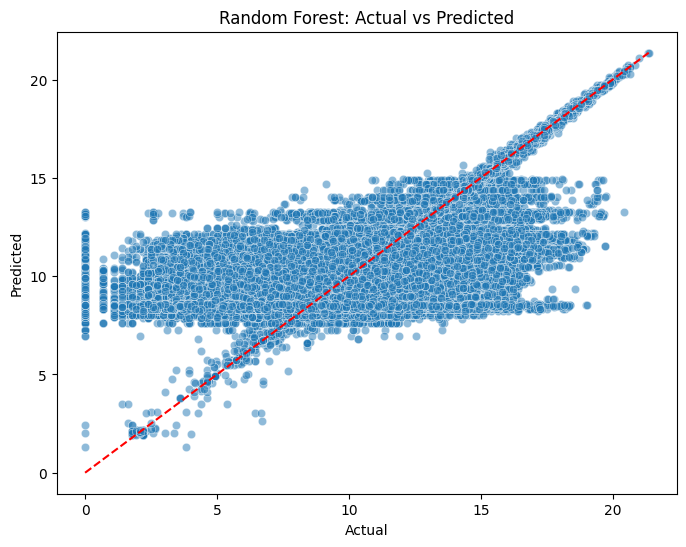

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, label='Random Forest')
sns.scatterplot(x=y_test, y=y_pred_et, alpha=0.5, label='Extra Trees')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Predicted vs Actual: Random Forest vs Extra Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split

# Train
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Results:")
print(f"MSE: {mse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")


Linear Regression Results:
MSE: 7.58
R² Score: 0.3211


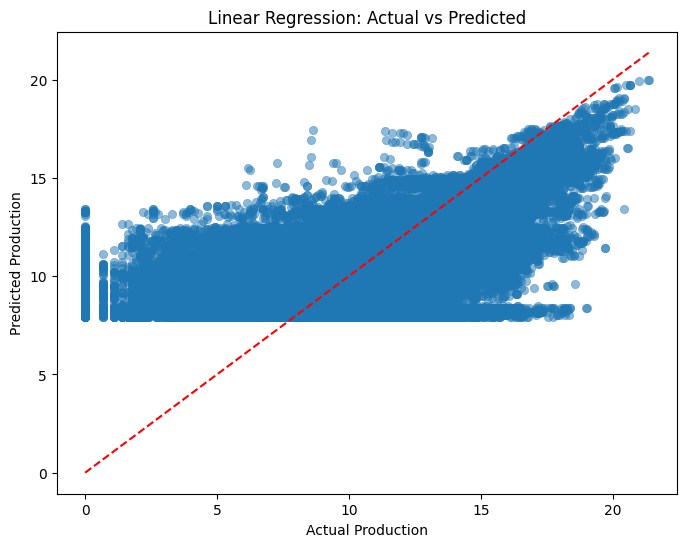

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_production, y=y_pred_lr, alpha=0.5, edgecolor=None)
plt.plot([y_test_production.min(), y_test_production.max()],
         [y_test_production.min(), y_test_production.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()


XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

# Evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print(f"MSE: {mse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")


XGBoost Results:
MSE: 7.28
R² Score: 0.3477
